In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scipy as sp
from scipy.integrate import odeint
from pyDOE import *
from scipy.stats.distributions import uniform
import os
import sympy
from IPython.display import display, Latex

In [4]:
mpl.rcParams.update({'font.size':15})
param_names = ['$\\alpha_1$', '$\\beta_2$', '$\\beta_3$', '$d_1$', '$d_2$', '$d_3$', '$h_1$', '$K_1$']
param_units = ['$mol. hr^{-1}$', '$hr^{-1}$', '$hr^{-1}$', '$hr^{-1}$', '$hr^{-1}$', '$hr^{-1}$', '', '$mol.$']
colors = ['#1f77b4','#ff7f0e','#2ca02c']

Image from Ananthasubramaniam et al. 2020 <br>
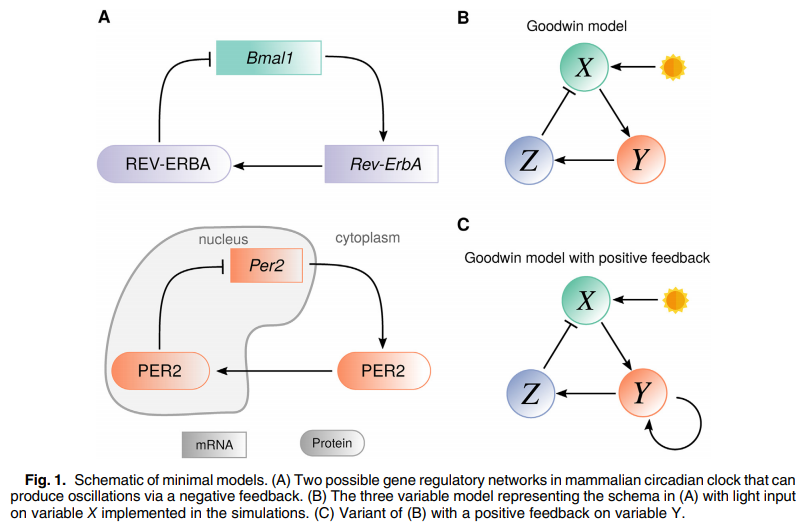

### Parameter ranges 
(Ananthasubramaniam et al. 2020)

- $d_1, d_2, d_3$ (degradation)                0.1-0.3
- $h$             (Hill coefficient)           5-12
- $K$             (half-maximum concentration) 0.25-1
- $\tau$          (intrinsic period)           22-26


### Equations for Goodwin model
$ \frac{dX}{dt} = \frac{\alpha_1}{1+(\frac{Z}{K})^h} - d_1X $ <br>
$ \frac{dY}{dt} = \beta_2X - d_2Y $ <br>
$ \frac{dZ}{dt} = \beta_3Y - d_3Z $

X = Bmal1 mRNA <br>
Y = Rev-ErbA mRNA <br>
Z = Rev-ErbA protein <br>

* In model from Ananthasubramaniam et al. 2020, $\alpha_1 = \beta_2 = \beta_3 = 1$

In [11]:
# define function to use with odeint
def equations(xyz, t):
    x, y, z = xyz
    dx = a1/(1+(z/k1)**h1) - d1*x
    dy = b2*x - d2*y
    dz = b3*y - d3*z
    return dx, dy, dz

### Comparing original and scaled Goodwin model

Original Model Timeseries


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

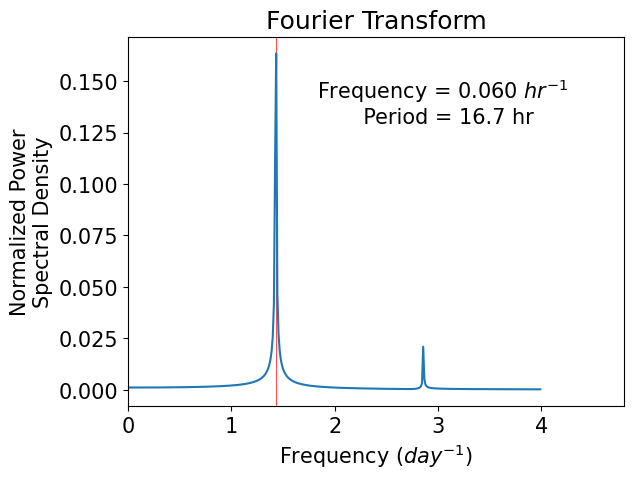

Period = 16.74
Modulation Depth = 0.22


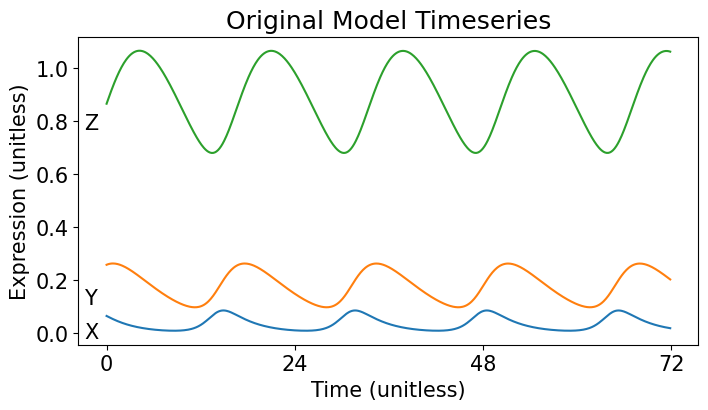


-----------------------------------------------------------------------------------------------------

Scaled Model Timeseries


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

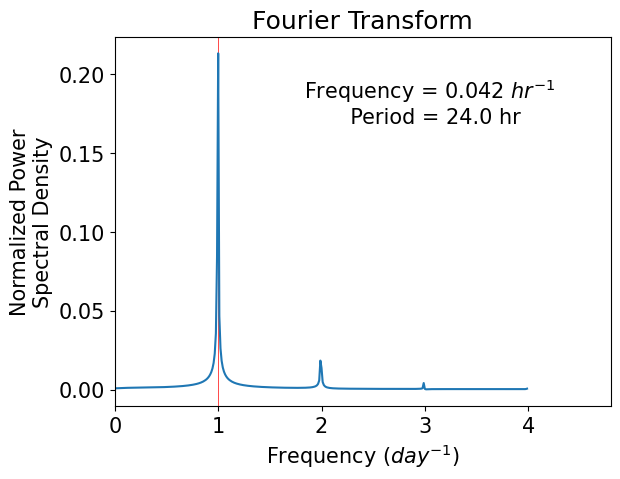

Period = 24.00
Modulation Depth = 0.22


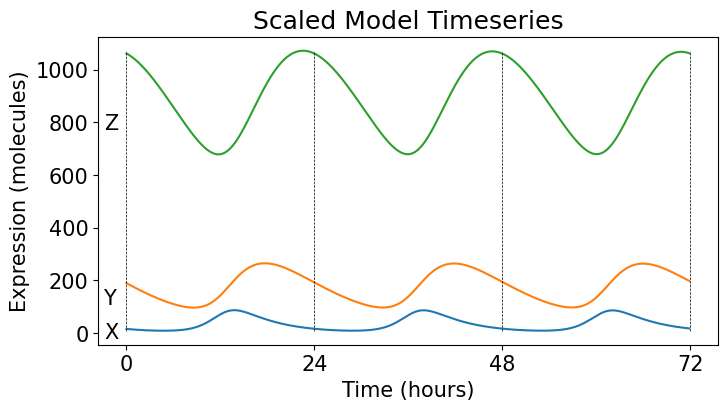


-----------------------------------------------------------------------------------------------------



In [50]:
# wrong case uses the original parameters from the unscaled Goodwin model
# right case uses the scaled parameters for 24hr periods and realistic molecule concentrations

for case in ['wrong','right']:

    xlabels = {'wrong': 'Time (unitless)', 'right': 'Time (hours)'}
    ylabels = {'wrong': 'Expression (unitless)', 'right': 'Expression (molecules)'}
    titles = {'wrong': 'Original Model Timeseries', 'right': 'Scaled Model Timeseries'}
    print(titles[case])

    ### define and print the parameters
    rxyz = {'wrong':[1,1,1,1], 'right':[0.001, 0.001, 0.001, 0.6976744186046511]} # scaling factors
    rx, ry, rz, rt = rxyz[case]

    a1 = (rt/rx)*1
    b2 = (rt*rx/ry)*1
    b3 = (rt*ry/rz)*1
    d1 = rt*0.3
    d2 = rt*0.2
    d3 = rt*0.2
    h1 = 10
    k1 = (1/rz)*0.5

    params = [a1, b2, b3, d1, d2, d3, h1, k1]
    for i,par in enumerate(params):
        # print(f"{{}} = {{}}".format(param_names[i], par))
        display(Latex(f'{{}} = {{}} {{}}'.format(param_names[i],par,param_units[i])))

    ### integrate the system using odeint
    days = 100 # number of days to run the simulation
    dStart = 10 # start day for plot
    dt = 0.1 # step size for integration with odeint
    init = [0,0,2] # initial points for X,Y,Z
    tvec = np.arange(0,24*days+dt,dt)
    tStart = 24*dStart # show oscillations after transient period
    tStop = tStart+24*(days-dStart) # days for fourier analysis
    tShow = tStart+24*3 # days to show in timeseries plot
    iStart = np.where(tvec>=tStart)[0][0]
    iStop = np.where(tvec>=tStop)[0][0]
    iShow = np.where(tvec>=tShow)[0][0]
    traj = odeint(equations, init, tvec)

    ### calculate the Fourier spectrum
    species = 2 # get Fourier spectrum for Z (Rev-ErbA protein)
    fdata = traj[iStart:iStop, species]
    npts = len(tplot)
    ymin, ymax = np.min(fdata), np.max(fdata)
    xf = sp.fft.fftfreq(len(fdata), dt)[1:int(npts/2)] # remove huge peak at 0
    yf = sp.fft.fft(fdata)[1:int(npts/2)] # remove huge peak at 0
    xf_plot = xf*24
    yf_plot = np.abs(yf)/np.sum(np.abs(yf))

    ### peak for Fourier spectrum
    fig = plt.figure()
    ypeak = np.max(np.abs(yf))
    xpeak = xf[np.where(np.abs(yf)==ypeak)[0]]
    for pt in xpeak:
        plt.axvline(x=pt*24, linestyle='-', color='red', linewidth=0.5)
    freq = r'Frequency = {:.3f}'.format(pt) + r' $hr^{-1}$'
    per = r'       Period = {:.1f} hr'.format(1/pt)
    pf_text = freq+"\n"+per

    ### plot the Fourier spectrum
    plt.plot(xf_plot, yf_plot)
    plt.xlim([0,0.2*24])
    plt.xlabel('Frequency ($day^{-1}$)')
    plt.ylabel('Normalized Power\nSpectral Density')
    plt.title('Fourier Transform')
    plt.text(x=0.42, y=0.7, s=pf_text, transform=fig.transFigure)
    if save_figure:
        plt.savefig(file_four, dpi=300, format='png', bbox_inches='tight')
    plt.show()

    print('Period = {:.2f}'.format(1/pt))

    ### plot the timeseries for X,Y,Z
    tplot = tvec[iStart:iShow]
    yplot = traj[iStart:iShow]
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ymin, ymax = np.min(yplot), np.max(yplot)
    for i in range(3):
        data = yplot[:,i]
        ax.plot(tplot, yplot[:,i], color=colors[i], label=handles[i])
        if i==2: # modulation depth of reverb-a
            rmin, rmax, ravg = np.min(data), np.max(data), np.mean(data)
            amp = (rmax-rmin)/2
            mod = amp/ravg
            print('Modulation Depth = {:.2f}'.format(mod))

    glines = np.arange(tplot[0], tplot[-1], 1/pt) # show strongest period
    glines = np.arange(tplot[0], tplot[-1]+24, 24)
    if case=='right': # add lines showing 24 hour period
        ax.vlines(glines, ymin, ymax, linestyles='--', color='black', linewidth=0.5)
    ax.set_ylabel(ylabels[case])
    locs = np.arange(tStart, tShow+24, 24)
    labels = (locs-locs[0]).astype(int)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.text(x=0.01, y=0.02, s='X', transform=ax.transAxes)
    ax.text(x=0.01, y=0.13, s='Y', transform=ax.transAxes)
    ax.text(x=0.01, y=0.7, s='Z', transform=ax.transAxes)
    ax.set_title(titles[case])
    ax.set_xlabel(xlabels[case])
    plt.show()

    print('\n-----------------------------------------------------------------------------------------------------\n')

***

### References

Bharath Ananthasubramaniam, Christoph Schmal, Hanspeter Herzel, Amplitude Effects Allow Short Jet Lags and Large Seasonal Phase Shifts in Minimal Clock Models, Journal of Molecular Biology, Volume 432, Issue 12, 2020, Pages 3722-3737, ISSN 0022-2836, https://doi.org/10.1016/j.jmb.2020.01.014.